# Adapted from Siang Lim weather-gc-ca-python code
https://github.com/csianglim/weather-gc-ca-python/blob/master/Part%20I%20-%20Data%20Extraction%20and%20Cleaning.ipynb

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.rrule import *
from dateutil.parser import *
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz
import fwi
import math


# Download just one month
**Right now all functions are downloading the full year of data from the API, have reached out to ECCC for fix...

In [3]:
month = "06" # January
year = "2023" # 2020
stationID = 51117 #Kelowna

base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=2".format(stationID, year, month)
api_endpoint = base_url + query_url

print("Click me to download CSV data:")
print(api_endpoint)

Click me to download CSV data:
http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51117&Year=2023&Month=06&timeframe=2


# Function to download ECCC daily weather data 

In [4]:
def getDailyData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=2".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)

# Download data for given station and date range
** Default ID is Kelowna ** <br>
Station ID's:<br>
Kelowna = 51117<br>
Cranbrook = 50818<br>
Williams Lake = 50820<br>
Quinsam = 209 ??<br>
Smithers = 48628<br>
Fort Nelson = 54098<br>

In [5]:
stationID = 51117
#start_date = datetime.strptime('Oct2021', '%b%Y')
#end_date = datetime.strptime('Dec2021', '%b%Y')
start_date = datetime.strptime('2021', '%Y')
end_date = datetime.strptime('2024', '%Y')

frames = []
weather_data = []
#Change YEARLY to MONTHLY when API fixed
for dt in rrule(YEARLY, dtstart=start_date, until=end_date):
    df = getDailyData(stationID, dt.year, dt.month)
    frames.append(df)

weather_data = pd.concat(frames)
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data['Max Temp (°C)'] = pd.to_numeric(weather_data['Max Temp (°C)'])

Plot Max Temp data

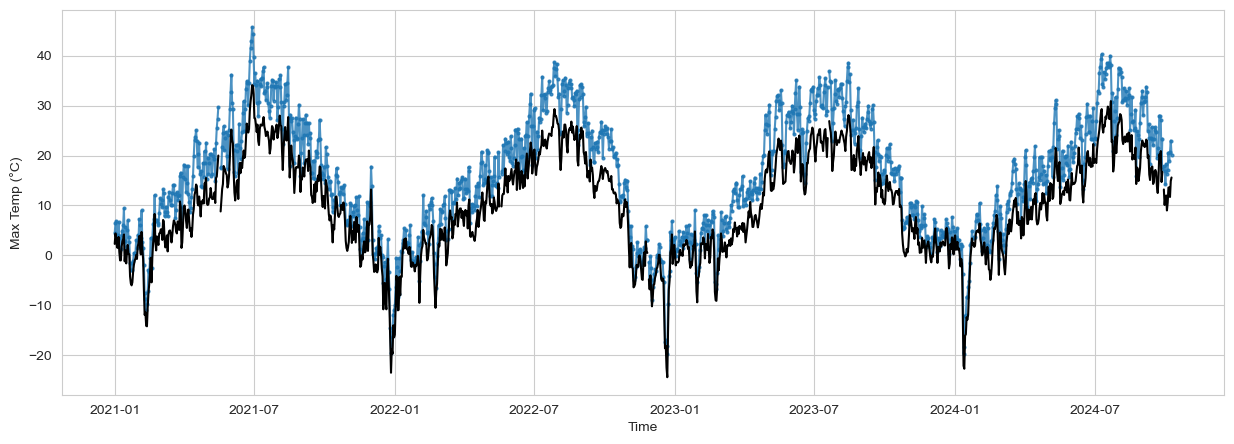

In [6]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Max Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(weather_data['Date/Time'], weather_data['Mean Temp (°C)'], '-k', alpha=1.0)
plt.ylabel('Max Temp (°C)')
plt.xlabel('Time')
plt.show()

Linear interpolation of wx data to fix holes

In [7]:
weather_data['Max Temp (°C)'] = weather_data['Max Temp (°C)'].interpolate()
weather_data['Total Precip (mm)'] = weather_data['Total Precip (mm)'].interpolate()


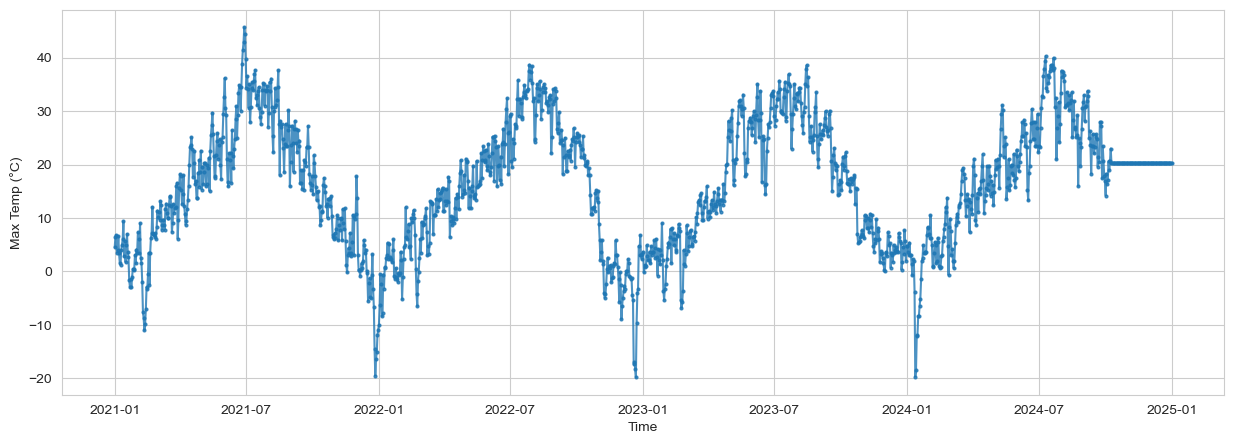

In [8]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Max Temp (°C)'], '-o', alpha=0.8, markersize=2)
#plt.plot(weather_data['Date/Time'], weather_data['Max Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Max Temp (°C)')
plt.xlabel('Time')
plt.show()

# Data analysis time
Firstly, need to identify shutdown and startup dates using 2024 guidance (3 days Tmax < 5 and 3 days Tmax > 12)<br>

### Correct index from wx data input
The input keeps the index for each year (0-364 repeating), could use it as is but idk...<br>
Create subset of Weather DataFrame for autumn (no shut down in summer)

In [9]:

weather_data.index = range(0,len(weather_data.index))

autumn = weather_data.loc[weather_data["Month"]>8, ['Date/Time','Max Temp (°C)']]

Algorithm note:<br>
Start - station_running = False<br>
if startup conditions met -> station_running = True<br>

Then choose the startup or shutdown loop to be running depending on running condition. This will stop the loop at the first occurrence of conditions instead of spitting out every day meeting criteria for startup/shutdown.

This could be done much more efficiently using np/pandas functionality but works for now.

OUTPUT: List of tuples by year of startup and shutdown dates

In [10]:
def shutdown_startup_dates(weather_data: dict, T_shutdown: int, T_startup: int, num_days: int):
    #Tmax = np.array(weather_data['Max Temp (°C)'])
    #m = Tmax < T_shutdown
    #me = np.r_[False, m, False]
    #idx = np.flatnonzero(me[:-1] != me[1:])
    #lens = idx[1::2]
    # Possible using NumPy

    shutdown = []
    startup = []
    station_running = False # Default because we start analysis on 1st day of year -> This won't work if stations aren't shutdown

    for idT,T in enumerate(weather_data['Max Temp (°C)']):
        if station_running == False: # Run startup loop

            # Startup loop
            if T > T_startup:
                if all(weather_data.at[ids,'Max Temp (°C)'] >= T_startup for ids in range(idT, idT + num_days)):
                    startup.append(weather_data.at[idT + num_days, 'Date/Time'])
                    station_running = True
   
        elif station_running == True: # Run shutdown loop

            # Shutdown loop
            if T < T_shutdown:
                if all(weather_data.at[ids,'Max Temp (°C)'] <= T_shutdown for ids in range(idT, idT + num_days)):
                    shutdown.append(weather_data.at[idT + num_days, 'Date/Time'])
                    station_running = False


    # Wrangle the dates to also get shutdown duration
    dt = pd.to_datetime(startup)
    dt1 = pd.to_datetime(shutdown)

    if len(dt) > len(dt1):
        dt = dt[1:]
        print(dt)
    
    days = (dt-dt1).days
    
    # Package into list of each year's shutdown and startup dates
    d = {'Shutdown Date': dt1, 'Startup Date': dt, 'Shutdown Duration': days}
    data = pd.DataFrame(data = d)
    
    return data

startup_shutdown_data = shutdown_startup_dates(weather_data, 5, 12, 3)
print(startup_shutdown_data)




DatetimeIndex(['2022-03-16', '2023-03-21', '2024-03-15'], dtype='datetime64[ns]', freq=None)
  Shutdown Date Startup Date  Shutdown Duration
0    2021-11-20   2022-03-16                116
1    2022-11-09   2023-03-21                132
2    2023-11-27   2024-03-15                109


Now we have the startup and shutdown dates for the station according to Beverly et al. 2024 guidance

**TO DO: Incorporate the WFWX data -> Need to download station data in a similar way to above process but from our server.**

**-> Calculating b adjustment coefficient from snow on ground data vs startup date, start at b=0.5 and decrease by tuning parameter x for every day that snow melted before thaw conditions met. Apply inverse squared rule to b?**

WE WOULDNT NEED ECCC DATA IF WE JUST RAN OUR STATIONS YEAR ROUND

Interim measure is to use the last DC calculated before shutdown and run calculations using ECCC data until shutdown date. If the station was not shutdown correctly and continued to calculate past the shutdown date from above, the DC is taken from that date. 

Sucks because it requires manually looking at WFWX and inputting the data below.

This process also currently ignores actual station startup date and DC used 

In [11]:
# INPUT actual station shutdown date and DC. If actual date after calculated shutdown, use DC on calculated date... From WFWX
DC_shutdown_actual = [
    [datetime.strptime('31/10/21', '%d/%m/%y'), 570], 
    [datetime.strptime('09/11/22', '%d/%m/%y'), 742], 
    [datetime.strptime('27/11/23', '%d/%m/%y'), 1050]
    ]

# Calculate shutdown DC

ASSUMPTIONS: <br> 
- The CFFDRS py DC calculation has rh in it as a conditional check. Doesn't affect anything so set at default of 50.<br>
- max temp is used for DC calculations

**To Do: Add in functionality for multiple startup/shutdown dates in a single year**

**Rejig this function to just calculate DC through a daterange, not for each year. It only needs the first shutdown. (what it already does...)**

Currently gives all DC values between actual and calculated shutdown

This is written to calculate for any number of years, but you only need the first year for our 'exercise'

shutdown data has the shutdown datetime and shutdown DC in the structure above 
shutdown calculated is just a list of datetimes

dc(dc_yda, temp, rh, prec, lat, mon, lat_adjust=True):

In [12]:
# TO DO: 
# Remove list functionality from this function - unnecessary...
# Change input names to reflect more general functionality - can be used to calc DC for any date range

# returns list of DCs
def single_year_shutdown_DC(last_DC, shutdown_date_actual, shutdown_date_calculated, weather_data):
    DC_shutdown = []

    number_days = (shutdown_date_calculated - shutdown_date_actual).days # difference between the actual and calculated shutdown
    #print(f"number of days between actual and calculated shutdown: {number_days}")
    
    if number_days != 0: #continue DC calculations
        # Case for when calculated shutdown is after actual shutdown  
        for single_date in (shutdown_date_actual + timedelta(n) for n in range(number_days + 1)):
                
            temp = weather_data.loc[weather_data['Date/Time'] == single_date, 'Max Temp (°C)'].iloc[0]
            rh = 50
            prec = weather_data.loc[weather_data['Date/Time'] == single_date, 'Total Precip (mm)'].iloc[0]
            lat = weather_data['Latitude (y)'].iloc[0]
            mon = single_date.month

            DC = fwi.dc(last_DC, temp, rh, prec, lat, mon, lat_adjust=True)
            DC_shutdown.append(DC)
            last_DC = DC


    else:
        DC_shutdown.append(last_DC)
    return DC_shutdown

DC_in = DC_shutdown_actual[0][1]
sd_ac = DC_shutdown_actual[0][0]
sd_c = startup_shutdown_data['Shutdown Date'].iloc[0]

first_shutdown_DC = single_year_shutdown_DC(DC_in, sd_ac, sd_c, weather_data)[-1]
print(first_shutdown_DC)

493.81092337918824


**Why are these two results different??**

*I guess we'll never know*

In [13]:
def calc_shutdown_DC(shutdown_data, shutdown_calculated, weather_data):
    DC_shutdown = []

    for date, data in shutdown_data:
        year = date.year
        shutdown_date_calculated = [x for x in shutdown_calculated if x.year == year] # take calculated shutdown date from shutdown_calculated list
        number_days = (shutdown_date_calculated[0] - date).days # difference between the actual and calculated shutdown
        DC_after_shutdown = []
        
        if number_days != 0: #continue DC calculations
            # Case for when calculated shutdown is after actual shutdown
            DC_yesterday = data
            
            for single_date in (date + timedelta(n) for n in range(number_days + 1)):
                
                temp = weather_data.loc[weather_data['Date/Time'] == single_date, 'Max Temp (°C)'].iloc[0]
                rh = 50
                prec = weather_data.loc[weather_data['Date/Time'] == single_date, 'Total Precip (mm)'].iloc[0]
                lat = weather_data['Latitude (y)'].iloc[0]
                mon = date.month

                DC = fwi.dc(DC_yesterday, temp, rh, prec, lat, mon, lat_adjust=True)
                DC_after_shutdown.append(DC)
                DC_yesterday = DC
            DC_shutdown.append(DC_after_shutdown[-1]) #DC at shutdown

        else:
            DC_shutdown.append(data)
    return DC_shutdown


dcs = calc_shutdown_DC(DC_shutdown_actual, startup_shutdown_data['Shutdown Date'], weather_data)
print(dcs)

[509.2948609982797, 742, 1050]


# Calculate Startup DC
TO DO: change the output to include year for each overwinter total.

In [14]:
def calc_overwinter_precip(shutdown_startup, weather_data): # returns list of overwinter precip for each year
    p_ow = []
    for i in range(len(shutdown_startup)):
        p_ow_yearly = 0
        for days in pd.date_range(shutdown_startup['Shutdown Date'].iloc[i], shutdown_startup['Startup Date'].iloc[i]):
            prec = weather_data.loc[weather_data['Date/Time'] == days, 'Total Precip (mm)'].iloc[0]
            p_ow_yearly += prec
        p_ow.append(p_ow_yearly)
    
    return p_ow

ow_p = calc_overwinter_precip(startup_shutdown_data, weather_data)
print(f"Total overwinter precip {ow_p}mm")

Total overwinter precip [88.50000000000001, 56.900000000000006, 90.6]mm


Helper function to get startup DC for each year

In [15]:
def calc_startup_DC(shutdown_DC, overwinter_precip, b):
    # Calculate moisture equivalent
    Qf = 800 * math.exp(-shutdown_DC/400)

    Qs = Qf + b * (3.94 * overwinter_precip)
        
    DC = 400 * math.log(800 / Qs)

    return DC
    

startup_DC = calc_startup_DC(first_shutdown_DC, ow_p[0], 0.5)
print(f"First startup DC = {startup_DC}")

First startup DC = 270.1987314128112


# Now to make like an egg and fry this scramble...

Take startup DC and calculate the DC through to shutdown, to cycle through to your specified date

In [16]:
query_date = datetime.strptime('17/09/24', '%d/%m/%y') # Date we are checking the DC for

# Copy dataframe to input the query date as our virtual shutdown
running_data = startup_shutdown_data.copy(deep=True)
running_data = running_data[['Startup Date', 'Shutdown Date', 'Shutdown Duration']]
#running_data.rename(columns={'Shutdown Duration': 'Running Duration'})
#running_data['Running Duration'] = running_data['Startup Date'] - running_data['Shutdown Date']
sd = running_data['Shutdown Date'].iloc[1:].tolist()
sd.append(query_date)
running_data['Shutdown Date'] = sd
print(running_data)



# Calculate DC when station running using our newly calculated startup codes:
shutdown_DC = first_shutdown_DC

for i in range(len(running_data)):
    dc = calc_startup_DC(shutdown_DC, ow_p[i], 0.5)
    print()
    print(f"DC at startup: {dc}")
    print(f"startup date: {running_data['Startup Date'].iloc[i]}")
    print(f"shutdown date: {running_data['Shutdown Date'].iloc[i]}")

    yearly_DC = single_year_shutdown_DC(dc, running_data['Startup Date'].iloc[i], running_data['Shutdown Date'].iloc[i], weather_data) # calc DC during running period
    shutdown_DC = yearly_DC[-1]
    print(f"DC at shutdown: {shutdown_DC}")


  Startup Date Shutdown Date  Shutdown Duration
0   2022-03-16    2022-11-09                116
1   2023-03-21    2023-11-27                132
2   2024-03-15    2024-09-17                109

DC at startup: 270.1987314128112
startup date: 2022-03-16 00:00:00
shutdown date: 2022-11-09 00:00:00
DC at shutdown: 670.4914566835446

DC at startup: 446.8802715210313
startup date: 2023-03-21 00:00:00
shutdown date: 2023-11-27 00:00:00
DC at shutdown: 900.8476322829904

DC at startup: 445.5570422437328
startup date: 2024-03-15 00:00:00
shutdown date: 2024-09-17 00:00:00
DC at shutdown: 947.0960432504446


Yeehaw. Now calculate using a few different b coefficients and visualize:

In [17]:
# Create dict storage for each DC
DC = {}
bs =[round(bs*0.1, 1) for bs in range(1, 10)]
shutdown_DC = first_shutdown_DC

for b in bs: #range of b values
    DC_year = []
    for i in range(len(running_data)): # iterate through years

        dc = calc_startup_DC(shutdown_DC, ow_p[i], b)

        yearly_DC = single_year_shutdown_DC(dc, running_data['Startup Date'].iloc[i], running_data['Shutdown Date'].iloc[i], weather_data) # calc DC during running period
        shutdown_DC = yearly_DC[-1]
        DC_year.extend(yearly_DC)
    DC['b = ' + str(b)] = DC_year

# get dates to add column
dates = []
for i in range(len(running_data)):
   dates.extend(pd.date_range(running_data['Startup Date'].iloc[i], running_data['Shutdown Date'].iloc[i], freq='d'))

DC['Date'] = dates

# create dataframe from DC data
DC_df = pd.DataFrame(data=DC)
DC_df = DC_df.set_index('Date').asfreq('D').reset_index()




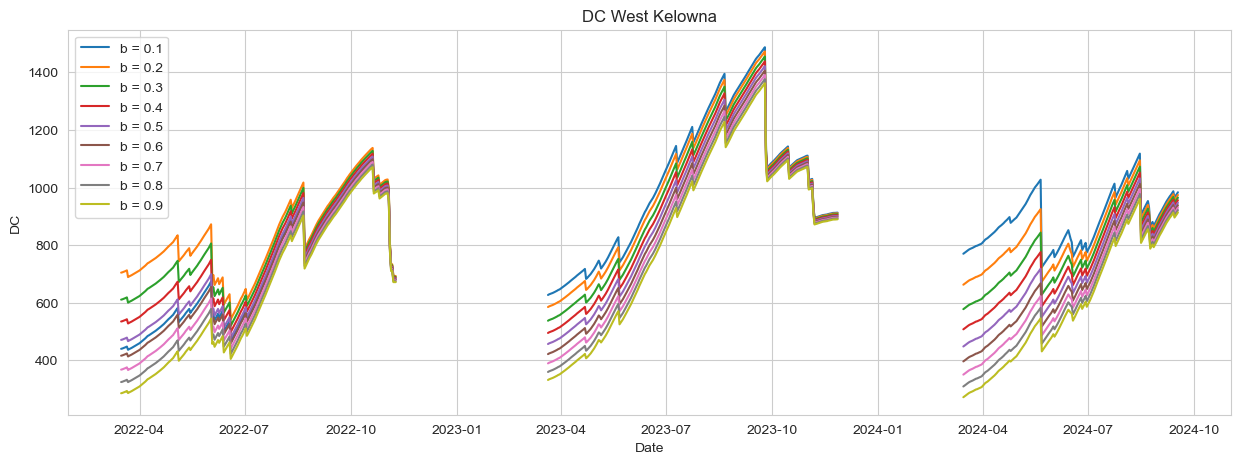

In [18]:
# Plot?
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))

plt.title('DC West Kelowna')

for i in DC_df.columns[1:]:

    plt.plot(DC_df['Date'], DC_df[i], label = i)


plt.ylabel('DC')
plt.xlabel('Date')
plt.legend()
plt.show()
